# 0. Setting

### Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# PLEASE SPECIFY THE PATH OF THIS FILE HERE
%cd '/content/drive/MyDrive/chanwoo/MLDL1'

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Utilities

In [2]:
def train_test_split_df(dataframe, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)

    # Shuffle the indices of the dataframe
    indices = np.random.permutation(len(dataframe))

    # Calculate the number of samples in the test set
    test_samples = int(len(dataframe) * test_size)

    # Split indices into train and test indices
    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]

    # Split dataframe into train and test sets using the indices
    train_data = dataframe.iloc[train_indices]
    test_data = dataframe.iloc[test_indices]

    return train_data, test_data

def train_test_split_np(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)

    # Shuffle the indices of the dataframe
    indices = np.random.permutation(len(y))

    # Calculate the number of samples in the test set
    test_samples = int(len(y) * test_size)

    # Split indices into train and test indices
    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]

    # Split dataframe into train and test sets using the indices
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]

    return train_X, train_y, test_X, test_y

def mean_squared_error(y_true, y_pred):
    # Calculate squared errors
    squared_errors = [(y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true))]

    # Calculate mean squared error
    mse = sum(squared_errors) / len(y_true)

    return mse

def r_squared(y_true, y_pred):
    # Calculate the mean of the true values
    mean_y_true = sum(y_true) / len(y_true)

    # Calculate the total sum of squares (TSS)
    tss = sum([(y - mean_y_true) ** 2 for y in y_true])

    # Calculate the residual sum of squares (RSS)
    rss = sum([(y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true))])

    # Calculate R-squared
    r2 = 1 - (rss / tss)

    return r2

def accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

# 1. Regularization

### 1-0. Data Setting

In [3]:
advertising = pd.read_csv("dataset/Advertising.csv", usecols=[1,2,3,4])
advertising.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
train_data, test_data = train_test_split_df(advertising)

X_train, y_train = np.array(train_data.drop("Sales", axis=1)), np.array(train_data.Sales)
X_test, y_test = np.array(test_data.drop("Sales", axis=1)), np.array(test_data.Sales)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(160, 3) (160,)
(40, 3) (40,)


### 1-1. Ridge Regression

__Closed Form Solution of Weights($\beta$) Estimation in Linear Regression__

Ordinary Least Squares Estimator
- $\hat{\beta}_{OLS} = (X^TX)^{-1}X^TY$

Ridge Estimator
- $\hat{\beta}_R = (X^TX + \lambda I)^{-1}X^TY$

In [5]:
class LinearRegression:
    def __init__(self):
        self.weights = None

    def fit(self, X, y):
        # Add a column of ones to X for the intercept(bias) term
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        # Calculate weights using the least squares method (closed form solution)
        self.weights = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

    def predict(self, X):
        # Add a column of ones to X for the intercept term
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate((ones, X), axis=1)

        # Predict using the linear regression model
        y_pred = X.dot(self.weights)

        return y_pred

In [7]:
class RidgeRegression:
    def __init__(self, alpha=1):
        self.weights = None
        self.alpha = alpha

    def fit(self, X, y):
        # Add a column of ones to X for the intercept(bias) term
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate((ones, X), axis=1)

        # Calculate weights using the least squares method with L2 regularization
        
        ##################
        # IMPLEMENT HERE #
        ##################
        
        self.weights = np.linalg.inv(X.T.dot(X) + self.alpha * np.eye(X.shape[1])).dot(X.T).dot(y)

        ##################
        ##################

    def predict(self, X):
        # Add a column of ones to X for the intercept(bias) term
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate((ones, X), axis=1)

        # Predict using the ridge regression model
        y_pred = X.dot(self.weights)

        return y_pred

In [8]:
ridge = RidgeRegression(alpha=1)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

print("MSE: ", mean_squared_error(y_test, y_pred))
print("r-squared: ", r_squared(y_test, y_pred))

MSE:  2.8446523092261353
r-squared:  0.9060890168129497


### 1-2. Lasso Regression

__Gradient of Loss with respect to Weights($\beta$) in Lasso Regression__

$ L(\beta) = (X\beta - y)^T(X\beta - y) + \lambda \times ||\beta||_1$

$ \frac{\partial}{\partial\beta}L = 2X^T(X\beta - y) + \lambda \times \text{sign}(\beta)$

In [9]:
class LassoRegression:
    def __init__(self, alpha=1):
        self.weights = None
        self.alpha = alpha

    def fit(self, X, y, max_iter=1000, lr=1e-5):
        # Add a column of ones to X for the intercept(bias) term
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate((ones, X), axis=1)

        # Initialize weights randomly
        self.weights = np.random.randn(X.shape[1])

        for _ in range(max_iter):
            # Calculate gradient of the loss function
            
            ##################
            # IMPLEMENT HERE #
            ##################

            grad = 2 * X.T.dot(X.dot(self.weights) - y) + self.alpha * np.sign(self.weights)
            
            ##################
            ##################
            
            # Update weights using the L1 regularization term
            self.weights -= lr * grad / X.shape[0]

    def predict(self, X):
        # Add a column of ones to X for the intercept term
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate((ones, X), axis=1)

        # Predict using the lasso regression model
        y_pred = X.dot(self.weights)

        return y_pred

In [10]:
lasso = LassoRegression(alpha=1)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

print("MSE: ", mean_squared_error(y_test, y_pred))
print("r-squared: ", r_squared(y_test, y_pred))

MSE:  3.8405002497726968
r-squared:  0.8732129219389971


# 2. Decision Tree Classification

### 2-0. Data Setting

In [11]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
label_dict = {0: "Setosa", 1: "Versicolor", 2: "Virginica"}

In [12]:
train_X, train_y, test_X, test_y = train_test_split_np(X, y)
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)
print()
print('With labels of {0: "Setosa", 1: "Versicolor", 2: "Virginica"},')
print('First five labels in training set:', train_y[:5])

(120, 4) (120,)
(30, 4) (30,)

With labels of {0: "Setosa", 1: "Versicolor", 2: "Virginica"},
First five labels in training set: [0 0 0 1 1]


### 2-1. Decision Tree Classifier

In [13]:
class DecisionTree:
    def __init__(self, min_samples=None):
        self.min_samples = min_samples

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        # Stopping criteria
        n_labels = len(np.unique(y))
        if (self.min_samples is not None and len(y) <= self.min_samples) or n_labels == 1:
            return np.argmax(np.bincount(y))

        feature_idx, threshold = self._best_split(X, y)
        left_indices = X[:, feature_idx] < threshold
        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[~left_indices], y[~left_indices]

        # Recursively grow the tree
        left_tree = self._grow_tree(X_left, y_left, depth + 1)
        right_tree = self._grow_tree(X_right, y_right, depth + 1)

        return [feature_idx, threshold, left_tree, right_tree]

    def _best_split(self, X, y):
        n_features = X.shape[1]
        best_feature_idx, best_threshold, min_entropy = None, None, float('inf')
        
        for feature_idx in range(n_features):
            
            ##################
            # IMPLEMENT HERE #
            ##################
            
            thresholds = np.unique(X[:, feature_idx])

            ##################
            ##################
            
            for threshold in thresholds:

                y_left = y[X[:, feature_idx] < threshold]
                y_right = y[X[:, feature_idx] >= threshold]

                entropy = self._entropy(y_left, y_right)
                if entropy < min_entropy:
                    best_feature_idx, best_threshold, min_entropy = feature_idx, threshold, entropy
                    
        return best_feature_idx, best_threshold

    def _entropy(self, y_left, y_right):
        n_left, n_right = len(y_left), len(y_right)
        n_total = n_left + n_right
        
        p_left = np.unique(y_left, return_counts=True)[1] / n_left
        p_right = np.unique(y_right, return_counts=True)[1] / n_right

        entropy_left = -np.sum(p_left * np.log(p_left))
        entropy_right = -np.sum(p_right * np.log(p_right))
        
        return (n_left / n_total) * entropy_left + (n_right / n_total) * entropy_right
    
    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])
    
    def _predict(self, x, tree):
        if not isinstance(tree, list):
            return tree

        feature_idx, threshold, left_tree, right_tree = tree
        if x[feature_idx] < threshold:
            return self._predict(x, left_tree)
        else:
            return self._predict(x, right_tree)

In [14]:
dt = DecisionTree(min_samples=5)
dt.fit(X, y)
pred_y = dt.predict(test_X)

print('Accuracy: ', accuracy(test_y, pred_y))

Accuracy:  0.9666666666666667


In [15]:
dt.tree

[2, 3.0, 0, [3, 1.8, [2, 5.0, [3, 1.7, 1, 2], [3, 1.6, 2, 1]], [2, 4.9, 2, 2]]]

# 3. Random Forest Classification

### 3-0. Data Setting

In [16]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
label_dict = {0: "Setosa", 1: "Versicolor", 2: "Virginica"}

In [17]:
train_X, train_y, test_X, test_y = train_test_split_np(X, y)
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)
print()
print('With labels of {0: "Setosa", 1: "Versicolor", 2: "Virginica"},')
print('First five labels in training set:', train_y[:5])

(120, 4) (120,)
(30, 4) (30,)

With labels of {0: "Setosa", 1: "Versicolor", 2: "Virginica"},
First five labels in training set: [2 0 2 0 0]


### 3-1. Decision Tree Classifier for Random Forest

In [18]:
class DecisionTreeForRF:
    def __init__(self, min_samples=None):
        self.min_samples = min_samples
        
    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        # Stopping criteria
        n_labels = len(np.unique(y))
        if (self.min_samples is not None and len(y) <= self.min_samples) or n_labels == 1:
            return np.argmax(np.bincount(y))

        # Find the best split
        feature_idx, threshold = self._best_split_with_random(X, y)
        left_indices = X[:, feature_idx] < threshold
        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[~left_indices], y[~left_indices]

        # Recursively grow the tree
        left_tree = self._grow_tree(X_left, y_left, depth + 1)
        right_tree = self._grow_tree(X_right, y_right, depth + 1)

        return [feature_idx, threshold, left_tree, right_tree]
    
    def _best_split_with_random(self, X, y):
        n_features = X.shape[1]
        best_feature_idx, best_threshold, min_entropy = None, None, float('inf')

        ##################
        # IMPLEMENT HERE #
        ##################

        # features = range(n_features)
        features = np.random.choice(n_features, int(np.sqrt(n_features)), replace=False)

        ##################
        ##################
        
        for feature_idx in features:
            thresholds = np.unique(X[:, feature_idx])

            for threshold in thresholds:
                y_left = y[X[:, feature_idx] < threshold]
                y_right = y[X[:, feature_idx] >= threshold]

                entropy = self._entropy(y_left, y_right)
                if entropy < min_entropy:
                    best_feature_idx, best_threshold, min_entropy = feature_idx, threshold, entropy

        return best_feature_idx, best_threshold

    def _entropy(self, y_left, y_right):
        n_left, n_right = len(y_left), len(y_right)
        n_total = n_left + n_right
        
        p_left = np.unique(y_left, return_counts=True)[1] / n_left
        p_right = np.unique(y_right, return_counts=True)[1] / n_right

        entropy_left = -np.sum(p_left * np.log(p_left))
        entropy_right = -np.sum(p_right * np.log(p_right))
        
        return (n_left / n_total) * entropy_left + (n_right / n_total) * entropy_right
    
    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])
    
    def _predict(self, x, tree):
        if not isinstance(tree, list):
            return tree

        feature_idx, threshold, left_tree, right_tree = tree
        if x[feature_idx] < threshold:
            return self._predict(x, left_tree)
        else:
            return self._predict(x, right_tree)

### 3-2. Random Forest Classifier

In [19]:
class RandomForestClassifier:
    def __init__(self, n_trees=100, min_samples=5):
        self.n_trees = n_trees
        self.min_samples = min_samples

    def fit(self, X, y):
        self.trees = [DecisionTreeForRF(min_samples=self.min_samples) for _ in range(self.n_trees)]

        for tree in self.trees:
            indices = np.random.choice(len(X), size=len(X), replace=True)
            tree.fit(X[indices], y[indices])

    def predict(self, X):
        predictions = np.stack([tree.predict(X) for tree in self.trees], axis=1)
        return np.array([np.argmax(np.bincount(pred)) for pred in predictions])

In [20]:
rf = RandomForestClassifier(n_trees=100, min_samples=5)
rf.fit(train_X, train_y)
pred_y = rf.predict(test_X)

print('Accuracy: ', accuracy(test_y, pred_y))

Accuracy:  0.9666666666666667


# 4. AdaBoost

### 4-0. Data Setting

In [21]:
df = pd.read_csv("dataset/Default.csv")
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [22]:
df['student'] = df.student.map({'No':0, 'Yes':1})
df['default'] = df.default.map({'No':-1, 'Yes':1})
df.head()

,default,student,balance,income
0,-1,0,729.526495,44361.625074
1,-1,1,817.180407,12106.134700
2,-1,0,1073.549164,31767.138947
3,-1,0,529.250605,35704.493935
4,-1,0,785.655883,38463.495879


In [23]:
y = df.default.values
X = df.drop("default", axis=1).values
train_X, train_y, test_X, test_y = train_test_split_np(X, y)

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)
print()
print('With labels of {-1: "No", 1: "Yes"},')
print('First five labels in training set:', train_y[:5])

(8000, 3) (8000,)
(2000, 3) (2000,)

With labels of {-1: "No", 1: "Yes"},
First five labels in training set: [-1 -1 -1 -1 -1]


### 4-1. Decision Tree Classifier for AdaBoost

In [24]:
class DecisionTreeBinaryClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        # Stopping criteria
        n_labels = len(np.unique(y))
        if (self.max_depth is not None and depth == self.max_depth) or n_labels == 1:
            y[y==-1] = 0
            return 2 * np.argmax(np.bincount(y)) - 1

        # Find the best split
        feature_idx, threshold = self._best_split(X, y)
        left_indices = X[:, feature_idx] < threshold
        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[~left_indices], y[~left_indices]

        # Recursively grow the tree
        left_tree = self._grow_tree(X_left, y_left, depth + 1)
        right_tree = self._grow_tree(X_right, y_right, depth + 1)

        return [feature_idx, threshold, left_tree, right_tree]

    def _best_split(self, X, y):
        n_features = X.shape[1]
        best_feature_idx, best_threshold, min_entropy = None, None, float('inf')

        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])

            for threshold in thresholds:
                y_left = y[X[:, feature_idx] < threshold]
                y_right = y[X[:, feature_idx] >= threshold]

                entropy = self._entropy(y_left, y_right)
                if entropy < min_entropy:
                    best_feature_idx, best_threshold, min_entropy = feature_idx, threshold, entropy

        return best_feature_idx, best_threshold

    def _entropy(self, y_left, y_right):
        n_left, n_right = len(y_left), len(y_right)
        n_total = n_left + n_right
        
        p_left = np.unique(y_left, return_counts=True)[1] / n_left
        p_right = np.unique(y_right, return_counts=True)[1] / n_right

        entropy_left = -np.sum(p_left * np.log(p_left))
        entropy_right = -np.sum(p_right * np.log(p_right))
        
        return (n_left / n_total) * entropy_left + (n_right / n_total) * entropy_right
    
    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])
    
    def _predict(self, x, tree):
        if not isinstance(tree, list):
            return tree

        feature_idx, threshold, left_tree, right_tree = tree
        if x[feature_idx] < threshold:
            return self._predict(x, left_tree)
        else:
            return self._predict(x, right_tree)

### 4-2 AdaBoost Binary Classifier

In [25]:
class AdaBoost:
    def __init__(self, n_estimators=100):
        self.n_estimators = n_estimators

    def fit(self, X, y):
        n_samples = len(X)
        weights = np.full(n_samples, 1 / n_samples)
        
        self.models = []
        for _ in range(self.n_estimators):
            model = DecisionTreeBinaryClassifier(max_depth=1)
            
            indices = np.random.choice(n_samples, size=n_samples, replace=True, p=weights)
            model.fit(X[indices], y[indices])

            y_pred = model.predict(X)
            error_rate = np.sum(y != y_pred) / n_samples

            alpha = 0.5 * np.log((1 - error_rate + 1e-7) / error_rate)
            
            ##################
            # IMPLEMENT HERE #
            ##################
            
            weights *= np.exp(-alpha * y * y_pred)
            weights /= np.sum(weights)
            
            ##################
            ##################

            self.models.append((alpha, model))

    def predict(self, X):
        n_samples = len(X)
        y_pred = np.zeros(n_samples)

        for alpha, model in self.models:
            y_pred += alpha * model.predict(X)

        return np.sign(y_pred)

In [26]:
ada = AdaBoost(n_estimators=100)
ada.fit(train_X, train_y)
pred_y = ada.predict(test_X)

print('Accuracy: ', accuracy(test_y, pred_y))

Accuracy:  0.9705


# 5. Hierarchical Clustering

### 5-0. Data Setting

In [27]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
label_dict = {0: "Setosa", 1: "Versicolor", 2: "Virginica"}

In [28]:
train_X, train_y, test_X, test_y = train_test_split_np(X, y)
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)
print()
print('With labels of {0: "Setosa", 1: "Versicolor", 2: "Virginica"},')
print('First five labels in training set:', train_y[:5])

(120, 4) (120,)
(30, 4) (30,)

With labels of {0: "Setosa", 1: "Versicolor", 2: "Virginica"},
First five labels in training set: [1 1 2 0 0]


### 5-1. Hierarchical Clustering

In [29]:
# Agglomerative clustering with Closest Pair Option
class HierarchicalClustering:
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters

    def fit(self, X):
        n_samples, n_features = X.shape
        self.labels = np.arange(n_samples)

        while len(np.unique(self.labels)) > self.n_clusters:
            min_dist = float('inf')
            for i in range(n_samples):
                for j in range(i + 1, n_samples):
                    if self.labels[i] != self.labels[j]:
                        dist = np.linalg.norm(X[i] - X[j])
                        if dist < min_dist:
                            min_dist = dist
                            merge_i, merge_j = i, j
                            
            ##################
            # IMPLEMENT HERE #
            ##################
            
            self.labels[self.labels == self.labels[merge_j]] = self.labels[merge_i]
            
            ##################
            ##################

    def get_labels(self):
        return self.labels

In [30]:
hc = HierarchicalClustering(n_clusters=3)
hc.fit(train_X)

In [31]:
hc.get_labels()

array([106, 106, 106,  95,  95,  95, 106, 106, 106, 106, 106, 106, 106,
        95,  95, 106, 106,  95,  95, 106, 106, 106, 106, 106,  95, 106,
        95, 106, 106, 106, 106, 106, 106,  95, 106,  95, 106,  95, 106,
        95, 106, 106,  95, 106,  95, 106,  95, 106, 106, 106, 106, 106,
       106, 106, 106, 106,  95, 106, 106,  95,  95, 106, 106, 106, 106,
       106, 106, 106, 106,  95,  95, 106, 106, 106, 106, 106, 106, 106,
       106,  95,  95, 106, 106, 106,  95,  85, 106,  95, 106, 106,  95,
       106,  95,  95,  95,  95,  95, 106, 106, 106, 106,  95,  95,  95,
        95,  95, 106,  95, 106, 106,  95,  95, 106, 106, 106,  95, 106,
       106, 106, 106])

# 6. Principal Component Analysis

### 6-0. Data Setting

In [33]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
label_dict = {0: "Setosa", 1: "Versicolor", 2: "Virginica"}

In [34]:
train_X, train_y, test_X, test_y = train_test_split_np(X, y)
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)
print()
print('With labels of {0: "Setosa", 1: "Versicolor", 2: "Virginica"},')
print('First five labels in training set:', train_y[:5])

(120, 4) (120,)
(30, 4) (30,)

With labels of {0: "Setosa", 1: "Versicolor", 2: "Virginica"},
First five labels in training set: [0 0 1 1 2]


In [35]:
# PCA with numpy
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        n_samples, n_features = X.shape

        # Calculate the mean of the data
        self.mean = np.mean(X, axis=0)

        # Center the data
        X_centered = X - self.mean

        # Calculate the covariance matrix
        self.cov_matrix = np.cov(X_centered, rowvar=False)

        # Calculate the eigenvalues and eigenvectors of the covariance matrix
        self.eigenvalues, self.eigenvectors = np.linalg.eigh(self.cov_matrix)

        # Sort the eigenvectors by decreasing eigenvalues
        idx = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[idx]
        self.eigenvectors = self.eigenvectors[:, idx]

        # Select the top n_components eigenvectors
        self.components = self.eigenvectors[:, :self.n_components]

    def transform(self, X):
        # Center the data
        X_centered = X - self.mean

        # Project the data onto the principal components
        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

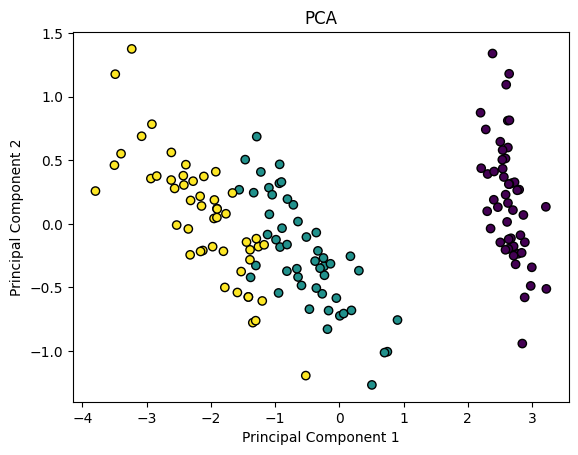

In [36]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# visualize X_pca
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.show()